In [49]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [50]:
transactional_data = pd.read_csv('../../data/interim/transactional_data_clean.csv')
exams_data = pd.read_csv('../../data/interim/exams_data_clean.csv')
geocode_data = pd.read_csv('../../data/interim/geocode_data_clean.csv')
economic_data = pd.read_csv('../../data/interim/economic_data_clean.csv')
demographic_data = pd.read_csv('../../data/interim/demographic_data_clean.csv')

In [51]:
transactional_data.head()

,patient__id,gender,date_of_birth,date_of_service,service__id,lab__id,cod_item,testing__cost
0,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0
1,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000638,13.0
2,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70001597,49.0
3,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000103,11.0
4,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000224,10.0


In [52]:
transactional_data['date_of_service'] = pd.to_datetime(transactional_data['date_of_service'])

In [53]:
# Merge entre transactional_data e exams_data pela coluna 'cod_item'
merged_data = transactional_data.merge(exams_data[['cod_item', 'testing__cost']], on='cod_item', suffixes=('_transaction', '_exam'))

# Calcular o lucro (profit)
merged_data['profit'] = merged_data['testing__cost_transaction'] - merged_data['testing__cost_exam']

# Selecionar apenas as colunas 'lab__id' e 'profit'
profit_data = merged_data[['lab__id', 'profit']]

/tmp/ipykernel_364359/3117616286.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(pareto_data_modified['lab__id'], rotation=90)


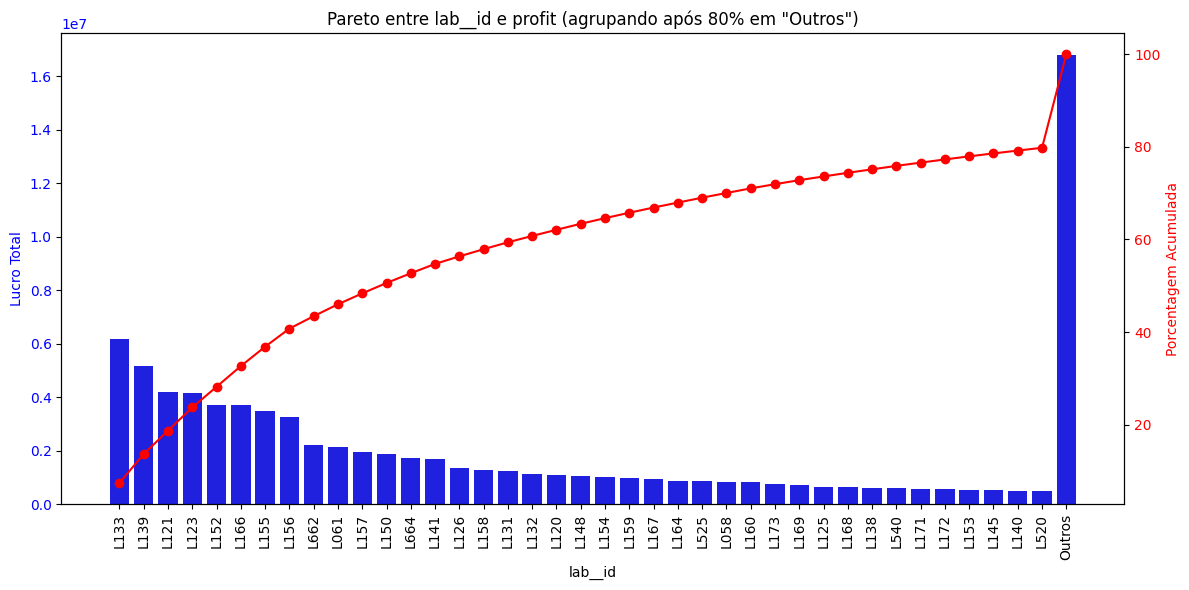

Lab IDs que compõem os 80% iniciais: ['L133', 'L139', 'L121', 'L123', 'L152', 'L166', 'L155', 'L156', 'L662', 'L061', 'L157', 'L150', 'L664', 'L141', 'L126', 'L158', 'L131', 'L132', 'L120', 'L148', 'L154', 'L159', 'L167', 'L164', 'L525', 'L058', 'L160', 'L173', 'L169', 'L125', 'L168', 'L138', 'L540', 'L171', 'L172', 'L153', 'L145', 'L140', 'L520']


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Exemplo de dados (substitua pelo seu DataFrame real)
# profit_data = pd.DataFrame({
#     'lab__id': [...],
#     'profit': [...]
# })

# 1. Calcular o lucro total por laboratório e ordenar em ordem decrescente
pareto_data = (
    profit_data
    .groupby('lab__id')['profit']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# 2. Calcular a porcentagem acumulada
pareto_data['cumulative_percentage'] = (
    pareto_data['profit'].cumsum() / pareto_data['profit'].sum() * 100
)

# Defina o limite desejado
threshold = 80

# 3. Separar labs até 80% e acima de 80%
mask = pareto_data['cumulative_percentage'] <= threshold
top_labs = pareto_data[mask].copy()     # Laboratórios que não ultrapassam 80%
others_labs = pareto_data[~mask].copy() # Laboratórios após 80%

# Obter a lista dos lab_ids que compõem os 80% iniciais
lab_ids_reached_80 = top_labs['lab__id'].astype(str).tolist()

# 4. Somar o lucro dos labs que estão no "others_labs"
others_profit = others_labs['profit'].sum()

# Criar uma linha "Outros"
others_row = pd.DataFrame({
    'lab__id': ['Outros'],
    'profit': [others_profit],
    'cumulative_percentage': [0]  # Valor temporário; será recalculado
})

# Concatenar top_labs com a linha "Outros"
pareto_data_modified = pd.concat([top_labs, others_row], ignore_index=True)

# 5. Recalcular a porcentagem acumulada para o novo DataFrame
pareto_data_modified['cumulative_percentage'] = (
    pareto_data_modified['profit'].cumsum() 
    / pareto_data_modified['profit'].sum() 
    * 100
)

# 6. Plotar o gráfico de Pareto com o DataFrame modificado
fig, ax1 = plt.subplots(figsize=(12, 6))

# Gráfico de barras para o lucro total
sns.barplot(
    data=pareto_data_modified, 
    x='lab__id', 
    y='profit', 
    ax=ax1, 
    color='b'
)
ax1.set_ylabel('Lucro Total', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(pareto_data_modified['lab__id'], rotation=90)

# Gráfico de linha para a porcentagem acumulada
ax2 = ax1.twinx()
ax2.plot(
    pareto_data_modified['lab__id'], 
    pareto_data_modified['cumulative_percentage'], 
    color='r', 
    marker='o'
)
ax2.set_ylabel('Porcentagem Acumulada', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Pareto entre lab__id e profit (agrupando após 80% em "Outros")')
plt.tight_layout()
plt.show()

# Exibe a lista dos lab_ids que compõem os 80%
print("Lab IDs que compõem os 80% iniciais:", lab_ids_reached_80)


In [55]:
# filtrar o transaction pelos labs_ids contidos em lab_ids_reached_80
filtered_transactional_data = transactional_data[
    transactional_data['lab__id'].astype(str).isin(lab_ids_reached_80)
]

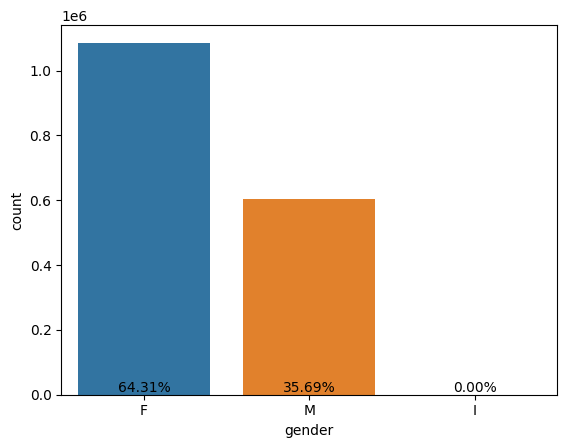

In [56]:
gender_counts = filtered_transactional_data['gender'].value_counts(normalize=True) * 100
sns.countplot(x='gender', hue='gender', data=filtered_transactional_data)

for i, count in enumerate(gender_counts):
    plt.text(i, count, f'{count:.2f}%', ha='center', va='bottom')

plt.show()

A partir disso observa-se um número mais expressivo de pacientes do sexo feminino, quase o dobro do masculino.
Vamos Explorar o ticket médio por gênero

Visando uma maior lucratividade da expansão, o zipcode de escolha deve considerar uma localidade onde se tem uma maior proporção de sexo feminino

In [59]:
filtered_transactional_data['age'] = filtered_transactional_data['date_of_service'].dt.year - pd.to_datetime(filtered_transactional_data['date_of_birth'], format='mixed').dt.year

/tmp/ipykernel_364359/135208279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_transactional_data['age'] = filtered_transactional_data['date_of_service'].dt.year - pd.to_datetime(filtered_transactional_data['date_of_birth'], format='mixed').dt.year


<Axes: xlabel='age', ylabel='Count'>

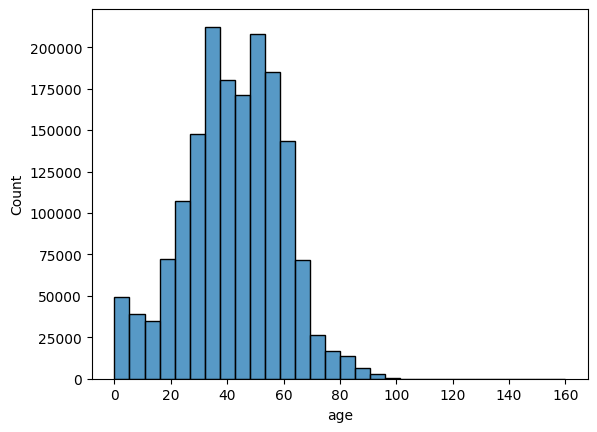

In [60]:
# faça uma distribuição por idade
sns.histplot(data=filtered_transactional_data, x='age', bins=30)

In [61]:
filtered_transactional_data.head()

,patient__id,gender,date_of_birth,date_of_service,service__id,lab__id,cod_item,testing__cost,age
0,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,43
1,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000638,13.0,43
2,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70001597,49.0,43
3,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000103,11.0,43
4,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000224,10.0,43


In [63]:
# Merge entre transactional_data e exams_data pela coluna 'cod_item'
merged_data = filtered_transactional_data.merge(exams_data[['cod_item', 'testing__cost']], on='cod_item', suffixes=('_transaction', '_exam'))

# Calcular o lucro (profit)
merged_data['profit'] = merged_data['testing__cost_transaction'] - merged_data['testing__cost_exam']

# Selecionar apenas as colunas 'lab__id' e 'profit'
profit_data_filter = merged_data

In [65]:
profit_data_filter.head()

,patient__id,gender,date_of_birth,date_of_service,service__id,lab__id,cod_item,testing__cost_transaction,age,testing__cost_exam,profit
0,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,43,1.78,7.22
1,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000638,13.0,43,2.46,10.54
2,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70001597,49.0,43,2.11,46.89
3,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000103,11.0,43,0.80,10.20
4,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000224,10.0,43,1.02,8.98


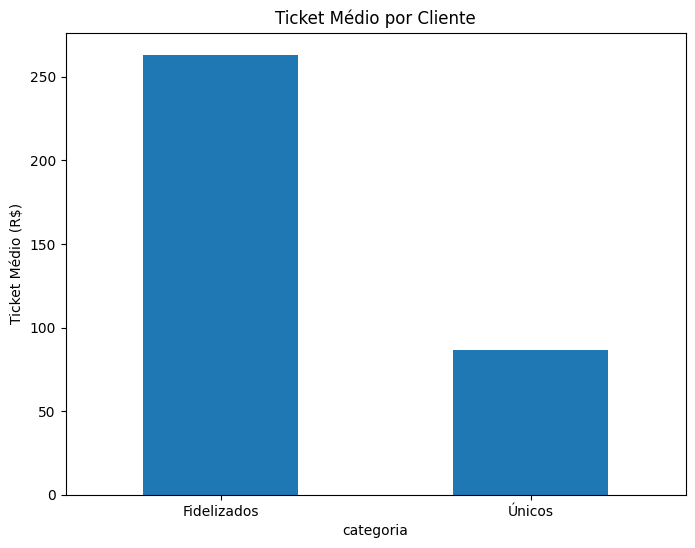

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Supondo que os dados estejam na variável filtered_transactional_data
df = profit_data_filter

# Agrupa por 'patient__id' para obter o total gasto e o número de transações por paciente
grouped = df.groupby('patient__id').agg({
    'profit': ['sum', 'count']
})
grouped.columns = ['total_cost', 'transaction_count']
grouped = grouped.reset_index()

# Cria uma nova coluna para classificar os clientes
grouped['categoria'] = grouped['transaction_count'].apply(lambda x: 'Únicos' if x == 1 else 'Fidelizados')

# Calcula o ticket médio (gasto total médio por paciente) para cada categoria
avg_ticket = grouped.groupby('categoria')['total_cost'].mean()

# Plota o gráfico de barras
plt.figure(figsize=(8,6))
avg_ticket.plot(kind='bar')
plt.ylabel('Ticket Médio (R$)')
plt.title('Ticket Médio por Cliente')
plt.xticks(rotation=0)
plt.show()


In [67]:
df_fidelizados = grouped[grouped['categoria'] == 'Fidelizados']

In [75]:
df_fidelizados_sorted = df_fidelizados.sort_values(by='transaction_count')

In [76]:
df_fidelizados_sorted

,patient__id,total_cost,transaction_count,categoria
207,1000983698-1,0.48,2,Fidelizados
217,100104272-BIO003,19.79,2,Fidelizados
179,1000726335-1,9.69,2,Fidelizados
184,1000789224-1,23.22,2,Fidelizados
188,1000815730-1,0.48,2,Fidelizados
...,...,...,...,...
219931,7659099707-1,9568.88,269,Fidelizados
193283,7656548765-1,34503.77,363,Fidelizados
192264,7600923838-1,92711.53,397,Fidelizados
135748,381241267-BIO002,7166.18,415,Fidelizados


In [77]:
# excluir o id 9999999-1 -> não é um paciente real
df_fidelizados_sorted = df_fidelizados_sorted[df_fidelizados_sorted['patient__id'] != '9999999-1']

In [78]:
filtered_transaction_by_fidelizados = transactional_data[
    transactional_data['patient__id'].isin(df_fidelizados_sorted['patient__id'])
]

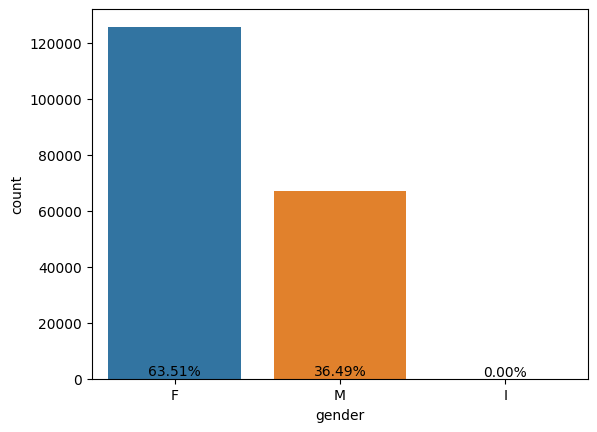

In [80]:
gender_counts = filtered_transaction_by_fidelizados['gender'].value_counts(normalize=True) * 100

# deixar apenas pacient_ids unicos (pode obter o primeiro)
filtered_transaction_by_fidelizados = filtered_transaction_by_fidelizados.drop_duplicates(subset=['patient__id'])

sns.countplot(x='gender', hue='gender', data=filtered_transaction_by_fidelizados)

for i, count in enumerate(gender_counts):
    plt.text(i, count, f'{count:.2f}%', ha='center', va='bottom')

plt.show()

In [82]:
filtered_transaction_by_fidelizados['age'] = filtered_transaction_by_fidelizados['date_of_service'].dt.year - pd.to_datetime(filtered_transaction_by_fidelizados['date_of_birth'], format='mixed').dt.year

<Axes: xlabel='age', ylabel='Count'>

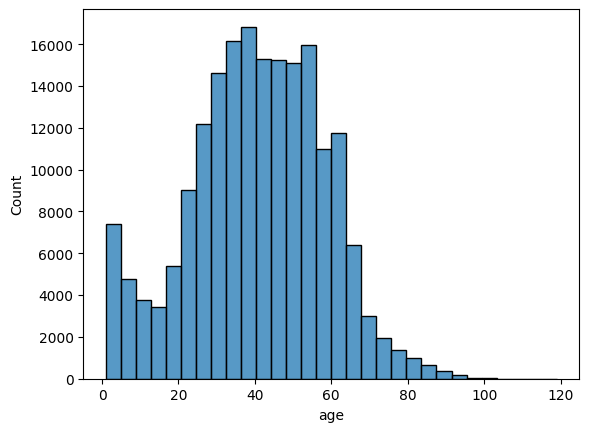

In [83]:
sns.histplot(data=filtered_transaction_by_fidelizados, x='age', bins=30)

In [92]:
# a partir desse historgram me retorne o range de idade dos top
# Define the age intervals
bins = [0, 4, 9, 14, 19, 24, 34, 44, 54, 59, 64, 74, 84, float('inf')]
labels = [
    '< 5 Years', '5 - 9 Years', '10 - 14 Years', '15 - 19 Years', 
    '20 - 24 Years', '25 - 34 Years', '35 - 44 Years', '45 - 54 Years', 
    '55 - 59 Years', '60 - 64 Years', '65 - 74 Years', '75 - 84 Years', 
    '85 Years >='
]

# Categorize ages into intervals
filtered_transaction_by_fidelizados['age_group'] = pd.cut(
    filtered_transaction_by_fidelizados['age'], bins=bins, labels=labels, right=True
)

# Count occurrences in each age group
age_group_counts = filtered_transaction_by_fidelizados['age_group'].value_counts().sort_values(ascending=False)

# Get the top 5 age groups
top_5_age_groups = age_group_counts.head(5)
top_5_age_groups

age_group
35 - 44 Years    40252
45 - 54 Years    38205
25 - 34 Years    34794
55 - 59 Years    19090
60 - 64 Years    13846
Name: count, dtype: int64

In [90]:
demographic_data['age_group'].value_counts()

age_group
< 5 Years        32620
5 - 9 Years      32620
10 - 14 Years    32620
15 - 19 Years    32620
20 - 24 Years    32620
25 - 34 Years    32620
35 - 44 Years    32620
45 - 54 Years    32620
55 - 59 Years    32620
60 - 64 Years    32620
65 - 74 Years    32620
75 - 84 Years    32620
85 Years >=      32620
Name: count, dtype: int64

In [94]:
filtered_transaction_by_fidelizados = filtered_transaction_by_fidelizados.head()

,patient__id,gender,date_of_birth,date_of_service,service__id,lab__id,cod_item,testing__cost,age,age_group
0,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,43,35 - 44 Years
10,10210848051-BIO003,F,1982-07-16 00:00:00,2019-01-30,571904618615-38,L133,70001115,39.0,37,35 - 44 Years
28,10210848087-BIO003,F,1989-07-03 00:00:00,2019-01-30,576608412729-91,L167,70000301,12.0,30,25 - 34 Years
37,10210845039-BIO003,M,2017-03-22 00:00:00,2019-01-25,575202384562-74,L156,70001103,42.0,2,< 5 Years
48,10210625160-BIO003,F,1987-12-02 00:00:00,2019-03-14,575202500726-74,L156,70003759,14.0,32,25 - 34 Years


In [97]:
# cruzar df_geocode com economic_data pelo zipcode e retornar apensa o lab__id e household_range do economic_data
teste = geocode_data.merge(
    economic_data[['zipcode', 'household_range']], 
    on='zipcode'
)[['lab__id', 'household_range']]

In [100]:
# merge o teste em filtered_transaction_by_fidelizados pelo lab__id
filtered_transaction_by_fidelizados = filtered_transaction_by_fidelizados.merge(
    teste, 
    on='lab__id', 
    how='left'
)


In [101]:
filtered_transaction_by_fidelizados

,patient__id,gender,date_of_birth,date_of_service,service__id,lab__id,cod_item,testing__cost,age,age_group,household_range_x,household_range_y
0,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,43,35 - 44 Years,< $10.000,< $10.000
1,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,43,35 - 44 Years,< $10.000,$10.000 - $14.999
2,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,43,35 - 44 Years,< $10.000,$15.000 - $24.999
3,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,43,35 - 44 Years,< $10.000,$25.000 - $34.999
4,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,43,35 - 44 Years,< $10.000,$35.000 - $49.999
...,...,...,...,...,...,...,...,...,...,...,...,...
18785745,7664164427-1,M,2003-08-20,2021-02-12,7664164427-1-1,L133,70000686,42.0,18,15 - 19 Years,$200.000 >=,$50.000 - $74.999
18785746,7664164427-1,M,2003-08-20,2021-02-12,7664164427-1-1,L133,70000686,42.0,18,15 - 19 Years,$200.000 >=,$75.000 - $99.999
18785747,7664164427-1,M,2003-08-20,2021-02-12,7664164427-1-1,L133,70000686,42.0,18,15 - 19 Years,$200.000 >=,$100.000 - $149.999
18785748,7664164427-1,M,2003-08-20,2021-02-12,7664164427-1-1,L133,70000686,42.0,18,15 - 19 Years,$200.000 >=,$150.000 - $199.999
